In [1]:
import os
import rioxarray
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import os.path
from pathlib import Path
import csv
import math
from osgeo import gdal, ogr, osr, gdalconst
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)

In [2]:
def tif_dict(strpath, masked=True, chunks=None, dsmatch=None):
    """
    Walks a directory of geotiffs and returns a dictionary of rioxarray DataArrays
    Args:
        strpath: directory name
        chunks: tuple of integers
        dsmatch: data array to match the directory of raster to
        masked: whether to mask by nodata, default is yes, pass masked=False if not desired
    Returns:
        a dictionary of rioxarrays
        
    Examples: 
       tif_dict(r'D:\BananaSplits')
       tif_dict(r'D:\BananaSplits', chunk=s(1,1024,1024))
    
    """

    check_dict = {}
    for root, dirs, files in os.walk(strpath):
        for file in files:
            if file.endswith('.tif'):
                print(file)
                if dsmatch is None:
                    if chunks is None:
                        check_dict[file] = rioxarray.open_rasterio(os.path.join(root,file),masked=masked)    
                    else:
                        check_dict[file] = rioxarray.open_rasterio(os.path.join(root,file), masked=masked, chunks=chunks)    
                else:
                    if chunks is None:
                        check_dict[file] = rioxarray.open_rasterio(os.path.join(root,file), masked=masked).rio.reproject_match(dsmatch)    
                    else:
                        check_dict[file] = rioxarray.open_rasterio(os.path.join(root,file), masked=masked, chunks=chunks).rio.reproject_match(dsmatch)    
                
    return check_dict

def location_sample(gdf, da, name_col):
    """
    Returns a dataframe of points sample from a DataArray by location at once
    
    Args:
        gdf: geodataframe of points
        da: DataArrau to sample:
        name_col: String to identify the location names
        
    Returns:
        Onshore location sample dataframe
    
    """

    lat = gdf.geometry.y.tolist()
    lon = gdf.geometry.x.tolist()
    xl = xr.DataArray(lon, dims=['location'],coords={"location":gdf[name_col].tolist()})
    yl = xr.DataArray(lat, dims=['location'],coords={"location":gdf[name_col].tolist()})
    
    dapt = da.sel(x=xl,y=yl,method="nearest")
    dfda = dapt.to_dataframe().reset_index()  
   
    return dfda



A good comparison piece would be: https://search.geoscience.nsw.gov.au/product/9233/7564550 in the Curnamona

here's a starting point comparison https://github.com/chudasama-bijal/QGIS-Plugin-Weights-of-Evidence-Model

An R version - https://github.com/GeoscienceAustralia/MPM-WofE

Get training data vector data - 1s

Choose mask layer if desired

Classes
- Favourable
- Unfavourable

Get list of evidence rasters

Studentized t contrast

Clip and make rasters the same details

Rasterise training data

Get count of data and not - e.g 1s and 0s in raster

Calculate weights
#633

Input weights rasters

calculate bayesian probs
#1590

In [5]:
## so possible exercise - convert the R version to python, possibly with robot assistance
## vectorize more in xarray

Borrow the test dataset from the Geoscience Australia example above by Arianne Ford

In [3]:
data = tif_dict(r'TESTDATA\\CalculateWeights')

Dist2Breccia.tif
Dist2Fault.tif
FaultDensity.tif
StratNo.tif


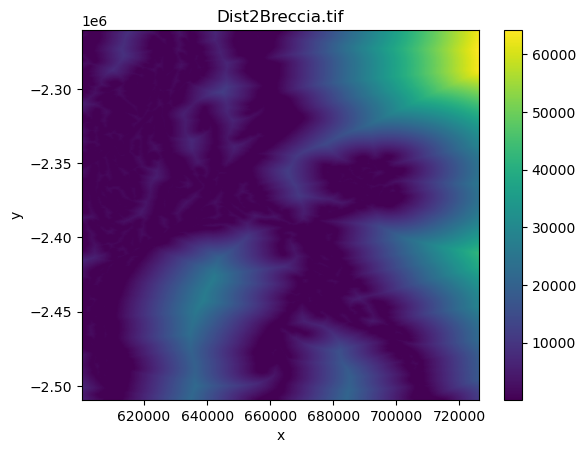

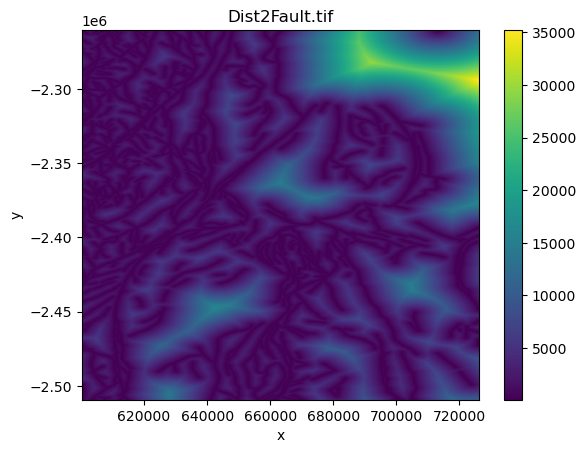

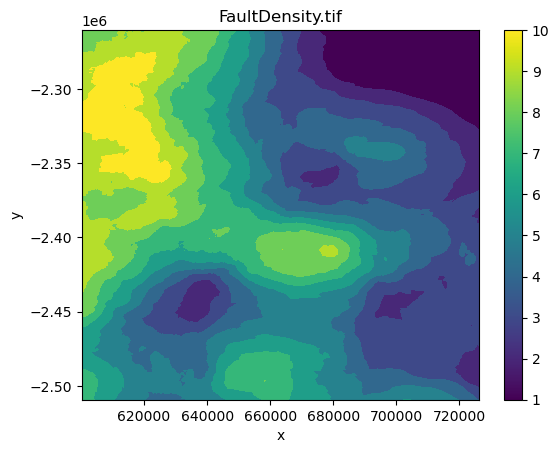

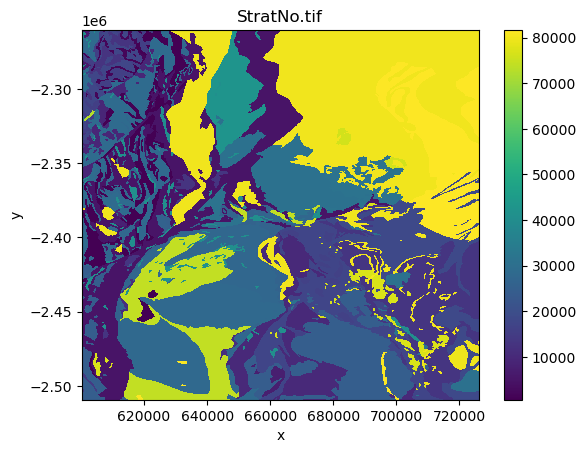

In [55]:
for d in data:
    fig, ax = plt.subplots()
    data[d].plot(ax=ax)
    plt.title(d)

In [56]:
for d in data:
    print(data[d].rio.bounds(), data[d].rio.crs, data[d].rio.resolution(), data[d].rio.nodata, data[d].dtype, d)

(600261.7688999996, -2509191.0156999994, 726161.7688999996, -2260491.0156999994) EPSG:7845 (100.0, -100.0) nan float64 Dist2Breccia.tif
(600261.7688999996, -2509191.0156999994, 726161.7688999996, -2260491.0156999994) EPSG:7845 (100.0, -100.0) nan float64 Dist2Fault.tif
(600261.7688999996, -2509191.0156999994, 726161.7688999996, -2260491.0156999994) EPSG:7845 (100.0, -100.0) None float32 FaultDensity.tif
(600261.7688999996, -2509191.0156999994, 726161.7688999996, -2260491.0156999994) EPSG:7845 (100.0, -100.0) nan float64 StratNo.tif


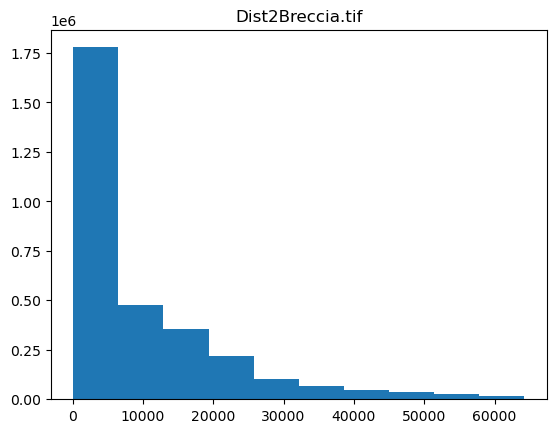

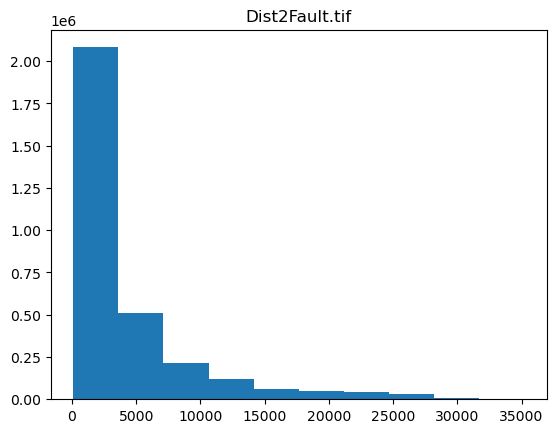

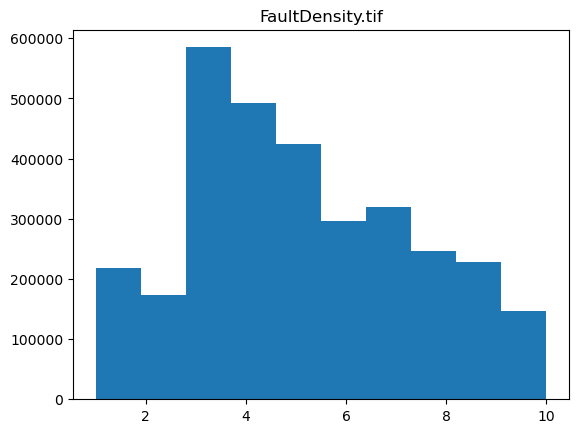

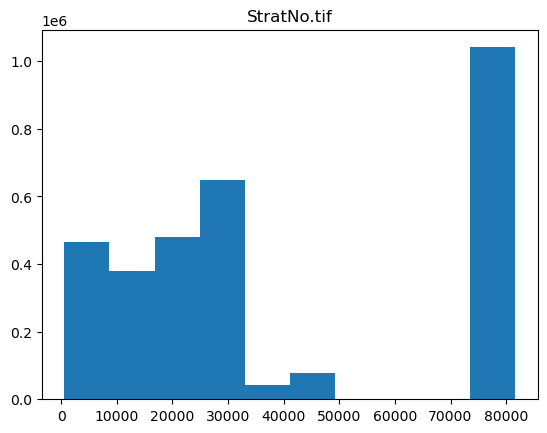

In [44]:
for d in data:
    fig, ax = plt.subplots()
    xr.plot.hist(data[d])
    plt.title(d)

In [5]:
iocg = gpd.read_file(r'TESTDATA\\CalculateWeights\\IOCG_Deposits.shp')

In [58]:
iocg

,Deposit,Status,Longitude,Latitude,Deposit_ty,Cu__Mt_,Zn__Mt_,Pb__Mt_,Ag__kt_,Au__t_,Source,DepositID,geometry
0,Abdy,Occurrence,139.951133,-20.611369,Iron-Oxide Cu-Au (-U-REE),0.00,0.0,NaN,NaN,NaN,GSQ,1,POINT (616378.824 -2374950.957)
1,Ace,Occurrence,140.777467,-20.984300,Iron-Oxide Cu-Au (-U-REE),0.00,0.0,NaN,NaN,NaN,GSQ,1,POINT (699675.507 -2420252.094)
2,Airport Prospect,Occurrence,140.181569,-20.303114,Iron-Oxide Cu-Au (-U-REE),0.00,0.0,NaN,NaN,NaN,GSQ,1,POINT (641895.388 -2342211.513)
3,Amethyst Castle,Occurrence,140.456531,-21.623617,Iron-Oxide Cu-Au (-U-REE),0.00,0.0,NaN,NaN,NaN,GSQ,1,POINT (662964.602 -2488687.592)
4,Artemis,Occurrence,140.798736,-20.980133,Iron-Oxide Cu-Au (-U-REE),0.00,0.0,NaN,NaN,NaN,GSQ,1,POINT (701893.908 -2419913.133)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Woomera,Occurrence,140.292400,-20.966156,Iron-Oxide Cu-Au (-U-REE),0.00,0.0,NaN,NaN,NaN,GSQ,1,POINT (649742.725 -2415655.053)
254,Kuridala,Occurrence,140.506000,-21.275150,IOCG,0.05,0.0,NaN,NaN,NaN,"Hoggard et al., 2020",1,POINT (670021.259 -2450706.873)
255,Merlin,Occurrence,140.492600,-21.662000,IOCG,0.03,0.0,NaN,NaN,NaN,"Hoggard et al., 2020",1,POINT (666447.214 -2493089.573)
256,Monakoff,Occurrence,140.688500,-20.625000,IOCG,0.03,0.0,NaN,NaN,NaN,"Hoggard et al., 2020",1,POINT (692602.422 -2380289.251)


<Axes: >

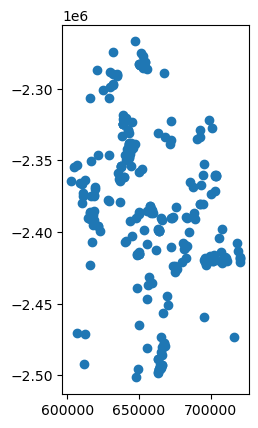

In [49]:
iocg.plot()

In [6]:
freqTable = {}
for d in data:
    freqTable[d] = data[d].groupby(data[d]).count()
    freqTable[d] = freqTable[d].to_dataframe()
    freqTable[d].columns = ['spatial_ref','count']
    freqTable[d] = freqTable[d].reset_index()   
    
depSig = {}
for d in data:
    depSig[d] = location_sample(iocg, data[d], 'Deposit')    
    
valCount = {}
for d in depSig:
    print(d)
    valCount[d] = freqTable[d].merge(depSig[d], left_on="group",right_on="group")    
    
valCount2 = {}
for d in valCount:
    gb = valCount[d].groupby('group').count().reset_index()
    gb = gb[['group','count']]
    gb.columns = ['value','n']
    valCount2[d] = gb    
    
freqTable2 = {}
for d in freqTable:
    freqTable2[d] = freqTable[d].merge(valCount2[d], left_on="group",right_on="value", how="left")
    freqTable2[d].fillna(0, inplace=True)
    
freqTableD = {}
for d in freqTable:
    freqTableD[d] = freqTable2[d].sort_values(by='group',ascending=False)    

In [283]:
for d in freqTable:
    print(d, freqTable[d])

Dist2Breccia.tif        group  spatial_ref   count
0      100.0            0  637030
1      200.0            0   44311
2      300.0            0   47127
3      400.0            0   39571
4      500.0            0   44427
..       ...          ...     ...
637  63800.0            0      58
638  63900.0            0      43
639  64000.0            0      28
640  64100.0            0      15
641  64200.0            0       3

[642 rows x 3 columns]
Dist2Fault.tif        group  spatial_ref   count
0      100.0            0  145305
1      200.0            0   95106
2      300.0            0  106895
3      400.0            0   90653
4      500.0            0  109910
..       ...          ...     ...
347  34800.0            0      18
348  34900.0            0      17
349  35000.0            0       9
350  35100.0            0       8
351  35200.0            0       1

[352 rows x 3 columns]
FaultDensity.tif    group  spatial_ref   count
0    1.0            0  217568
1    2.0            0  1737

In [288]:
freqTable2['Dist2Breccia.tif']

,group,spatial_ref,count,value,n
0,100.0,0,637030,100.0,103.0
1,200.0,0,44311,200.0,13.0
2,300.0,0,47127,300.0,6.0
3,400.0,0,39571,400.0,6.0
4,500.0,0,44427,500.0,7.0
...,...,...,...,...,...
637,63800.0,0,58,0.0,0.0
638,63900.0,0,43,0.0,0.0
639,64000.0,0,28,0.0,0.0
640,64100.0,0,15,0.0,0.0


In [290]:
freqTableD['FaultDensity.tif']

,group,spatial_ref,count,value,n
9,10.0,0,146466,10.0,5.0
8,9.0,0,227565,9.0,17.0
7,8.0,0,247123,8.0,40.0
6,7.0,0,320305,7.0,73.0
5,6.0,0,297054,6.0,52.0
4,5.0,0,424177,5.0,24.0
3,4.0,0,492049,4.0,27.0
2,3.0,0,585125,3.0,20.0
1,2.0,0,173701,0.0,0.0
0,1.0,0,217568,0.0,0.0


In [291]:
freqTableD['Dist2Breccia.tif']

,group,spatial_ref,count,value,n
641,64200.0,0,3,0.0,0.0
640,64100.0,0,15,0.0,0.0
639,64000.0,0,28,0.0,0.0
638,63900.0,0,43,0.0,0.0
637,63800.0,0,58,0.0,0.0
...,...,...,...,...,...
4,500.0,0,44427,500.0,7.0
3,400.0,0,39571,400.0,6.0
2,300.0,0,47127,300.0,6.0
1,200.0,0,44311,200.0,13.0


In [19]:
#pixel size in km
unitArea = 1
confCont = 2 ## user supplied


class_km2 = [data[d].rio.resolution()[0] / 1000, abs(data[d].rio.resolution()[1] / 1000)]  #pos y value
class_km2

[0.1, 0.1]

In [20]:
#descending, ascending, categorical
## need to max this dataclass list
dataclass = ['a','a','d','c']
colnames = ["CLASS", "CLASS_AREA", "AREA_SQ_KM", "AREA_UNITS", "NO_POINTS", "WPLUS", "S_WPLUS", "WMINUS", "S_WMINUS", "CONTRAST", "S_CONTRAST", "STUDC", "GEN_CLASS", "WEIGHT", "W_STD"]

In [21]:
makeWts = {}

for d in freqTable2:
    makeWts[d] = pd.DataFrame(columns=colnames)

In [86]:
# go through raster names and get corresponding class - make part of setup dict?
# can consolidate this more, but possible at sake of clarity
# assignment note https://github.com/pandas-dev/pandas/issues/16187

for index, d in enumerate(data.keys()):

    dc = dataclass[index]
    
    print(d, dc)
                          
    if dc != 'c':
        print(d, dc)
        if dc == 'd': ## doing the decending versions - bigger data better  . e.g. freqTableD
            makeWts[d]['CLASS'] = freqTableD[d]['group']
            makeWts[d]['CLASS_AREA'] = freqTableD[d]['count'] * class_km2[0]  * class_km2[1]
            makeWts[d]['AREA_SQ_KM'] = freqTableD[d]['count'] * class_km2[0]  * class_km2[1]                                                         
            makeWts[d]['AREA_UNITS'] = freqTableD[d]['count'] * class_km2[0]  * unitArea
            makeWts[d]['NO_POINTS'] = freqTableD[d]['n']

            makeWts[d]['AREA_SQ_KM'] = makeWts[d]['AREA_SQ_KM'].cumsum()
            makeWts[d]['AREA_UNITS'] = makeWts[d]['AREA_SQ_KM'] * unitArea
            makeWts[d]['NO_POINTS'] = makeWts[d]['NO_POINTS'].cumsum()

        if dc == 'a': ## doing the ascending versions - smaller data 'better'

            makeWts[d]['CLASS'] = freqTable2[d]['group']
            makeWts[d]['CLASS_AREA'] = freqTable2[d]['count'] * class_km2[0]  * class_km2[1]
            makeWts[d]['AREA_SQ_KM'] = freqTable2[d]['count'] * class_km2[0]  * class_km2[1]                                                         
            makeWts[d]['AREA_UNITS'] = freqTable2[d]['count'] * class_km2[0]  * unitArea
            makeWts[d]['NO_POINTS'] = freqTable2[d]['n']

            makeWts[d]['AREA_SQ_KM'] = makeWts[d]['AREA_SQ_KM'].cumsum()
            makeWts[d]['AREA_UNITS'] = makeWts[d]['AREA_SQ_KM'] * unitArea
            makeWts[d]['NO_POINTS'] = makeWts[d]['NO_POINTS'].cumsum()
         
        
        makeWts[d]['s'] = makeWts[d]['AREA_UNITS'].max()
        makeWts[d]['b'] = makeWts[d]['AREA_UNITS']
        makeWts[d]['ds'] = iocg.shape[0]
        makeWts[d]['db'] = makeWts[d]['NO_POINTS']

        makeWts[d]['priorprob'] = makeWts[d]['ds'] / makeWts[d]['s']

        for c in ["WPLUS", "S_WPLUS", "WMINUS", "S_WMINUS", "CONTRAST", "S_CONTRAST", "STUDC"]:
            makeWts[d].loc[makeWts[d]['db'] == 0, c] = 0

        makeWts[d].loc[makeWts[d]['db'] == makeWts[d]['ds'], 'db'] = makeWts[d]['db'] - 0.99

        makeWts[d].loc[(makeWts[d]['s'] - makeWts[d]['db']) <= (makeWts[d]['ds'] - makeWts[d]['db']), 'b'] \
            = makeWts[d]['s'] + makeWts[d]['db'] - makeWts[d]['ds'] - 0.99

        makeWts[d].loc[(makeWts[d]['b'] - makeWts[d]['db']) <= 0.0, 'b'] = makeWts[d]['db'] + 1

        makeWts[d]['pbd'] = makeWts[d]['db'] / makeWts[d]['ds']
        makeWts[d]['pbdb'] = (makeWts[d]['b'] - makeWts[d]['db']) / (makeWts[d]['s'] - makeWts[d]['ds'])
        makeWts[d]['ls'] = makeWts[d]['pbd'] / makeWts[d]['pbdb']
        makeWts[d]['wp'] = np.log(makeWts[d]['ls'])
        makeWts[d]['WPLUS'] = makeWts[d]['wp']    

        makeWts[d]['vp'] = (1.0 / makeWts[d]['db']) + (1.0 / (makeWts[d]['b'] - makeWts[d]['db']) )
        makeWts[d]['sp'] = np.sqrt(makeWts[d]['vp'])          
        makeWts[d]['S_WPLUS'] = makeWts[d]['sp']    

        makeWts[d]['pbbd'] = (makeWts[d]['ds'] - makeWts[d]['db']) / makeWts[d]['ds']
        makeWts[d]['pbbdb'] = (makeWts[d]['s'] - makeWts[d]['b'] - makeWts[d]['ds'] + makeWts[d]['db']) / (makeWts[d]['s'] - makeWts[d]['ds'])
        makeWts[d]['ln1'] = makeWts[d]['pbbd'] / makeWts[d]['pbbdb']
        makeWts[d]['wm'] = np.log(makeWts[d]['ln1'])
        makeWts[d]['WMINUS'] = makeWts[d]['wm']    

        makeWts[d]['vm'] = (1.0 / (makeWts[d]['ds'] - makeWts[d]['db'])) + (1.0 / (makeWts[d]['s'] - makeWts[d]['b']  - makeWts[d]['ds'] +- makeWts[d]['db']) ) 
        makeWts[d]['sm'] = np.sqrt(makeWts[d]['vm'])          
        makeWts[d]['S_WMINUS'] = makeWts[d]['sm']    

        makeWts[d]['c'] = makeWts[d]['wp'] - makeWts[d]['wm']
        makeWts[d]['CONTRAST'] = makeWts[d]['c']

        makeWts[d]['sc'] = np.sqrt(makeWts[d]['vp'] + makeWts[d]['vm'])
        makeWts[d]['S_CONTRAST'] = makeWts[d]['sc']
        makeWts[d]['STUDC'] = makeWts[d]['c'] / makeWts[d]['sc']    

        maxConf = makeWts[d]['STUDC'].idxmax()
        maxCont = makeWts[d]['CONTRAST'].idxmax()

        if maxConf < confCont:
            makeWts[d]['GEN_CLASS'] = 999
            makeWts[d]['WEIGHT'] = 0.0
            makeWts[d]['W_STD'] = 0.0
        else:
            makeWts[d].loc[(makeWts[d]['CLASS'] <= makeWts[d]['CLASS'].max()) & (makeWts[d]['CONTRAST'] <= makeWts[d]['CONTRAST'].max()) \
                          & (makeWts[d]['STUDC'] <= makeWts[d]['STUDC'].max()) & (makeWts[d].index <= maxCont)\
                          , ['GEN_CLASS','WEIGHT','W_STD']]  = [2, makeWts[d].iloc[maxCont]['WPLUS'], makeWts[d].iloc[maxCont]['S_WPLUS']]

            makeWts[d].loc[(makeWts[d]['CLASS'] <= makeWts[d]['CLASS'].max()) & (makeWts[d]['CONTRAST'] <= makeWts[d]['CONTRAST'].max()) \
                          & (makeWts[d]['STUDC'] <= makeWts[d]['STUDC'].max()) & (makeWts[d].index > maxCont)\
                          , ['GEN_CLASS','WEIGHT','W_STD']]  = [1, makeWts[d].iloc[maxCont]['WMINUS'], makeWts[d].iloc[maxCont]['S_WMINUS']]

    
    if dc == 'c':
        makeWts[d]['CLASS'] = freqTable2[d]['group']
        makeWts[d]['CLASS_AREA'] = freqTable2[d]['count'] * class_km2[0]  * class_km2[1]
        makeWts[d]['AREA_SQ_KM'] = freqTable2[d]['count'] * class_km2[0]  * class_km2[1]                                                         
        makeWts[d]['AREA_UNITS'] = freqTable2[d]['count'] * class_km2[0]  * class_km2[1] * unitArea
        makeWts[d]['NO_POINTS'] = freqTable2[d]['n']
        
        makeWts[d]['s'] = makeWts[d]['AREA_UNITS'].sum()
        makeWts[d]['b'] = makeWts[d]['AREA_UNITS']
        makeWts[d]['ds'] = iocg.shape[0]
        makeWts[d]['db'] = makeWts[d]['NO_POINTS']
        
        makeWts[d]['priorprob'] = makeWts[d]['ds'] / makeWts[d]['s']

        for c in ["WPLUS", "S_WPLUS", "WMINUS", "S_WMINUS", "CONTRAST", "S_CONTRAST", "STUDC"]:
            makeWts[d].loc[makeWts[d]['db'] == 0, c] = 0
        
        makeWts[d].loc[makeWts[d]['db'] == makeWts[d]['ds'], 'db'] = makeWts[d]['db'] - 0.99

        makeWts[d].loc[makeWts[d]['db'] == 0.001, 'db'] = makeWts[d]['ds'] - 0.99
        
        makeWts[d].loc[(makeWts[d]['s'] - makeWts[d]['db']) <= (makeWts[d]['ds'] - makeWts[d]['db']), 'b'] \
            = makeWts[d]['s'] + makeWts[d]['db'] - makeWts[d]['ds'] - 0.99
        
        makeWts[d].loc[(makeWts[d]['b'] - makeWts[d]['db']) <= 0.0, 'b'] = makeWts[d]['db'] + 1
        
        makeWts[d]['pbd'] = makeWts[d]['db'] / makeWts[d]['ds']
        makeWts[d]['pbdb'] = (makeWts[d]['b'] - makeWts[d]['db']) / (makeWts[d]['s'] - makeWts[d]['ds'])
        makeWts[d]['ls'] = makeWts[d]['pbd'] / makeWts[d]['pbdb']
        makeWts[d]['wp'] = np.log(makeWts[d]['ls'])
        makeWts[d]['WPLUS'] = makeWts[d]['wp']    

        makeWts[d]['vp'] = (1.0 / makeWts[d]['db']) + (1.0 / (makeWts[d]['b'] - makeWts[d]['db']) )
        makeWts[d]['sp'] = np.sqrt(makeWts[d]['vp'])          
        makeWts[d]['S_WPLUS'] = makeWts[d]['sp']    

        makeWts[d]['pbbd'] = (makeWts[d]['ds'] - makeWts[d]['db']) / makeWts[d]['ds']
        makeWts[d]['pbbdb'] = (makeWts[d]['s'] - makeWts[d]['b'] - makeWts[d]['ds'] + makeWts[d]['db']) / (makeWts[d]['s'] - makeWts[d]['ds'])
        makeWts[d]['ln1'] = makeWts[d]['pbbd'] / makeWts[d]['pbbdb']
        makeWts[d]['wm'] = np.log(makeWts[d]['ln1'])
        makeWts[d]['WMINUS'] = makeWts[d]['wm']    

        makeWts[d]['vm'] = (1.0 / (makeWts[d]['ds'] - makeWts[d]['db'])) + (1.0 / (makeWts[d]['s'] - makeWts[d]['b']  - makeWts[d]['ds'] +- makeWts[d]['db']) ) 
        makeWts[d]['sm'] = np.sqrt(makeWts[d]['vm'])          
        makeWts[d]['S_WMINUS'] = makeWts[d]['sm']    

        makeWts[d]['c'] = makeWts[d]['wp'] - makeWts[d]['wm']
        makeWts[d]['CONTRAST'] = makeWts[d]['c']

        makeWts[d]['sc'] = np.sqrt(makeWts[d]['vp'] + makeWts[d]['vm'])
        makeWts[d]['S_CONTRAST'] = makeWts[d]['sc']
        makeWts[d]['STUDC'] = makeWts[d]['c'] / makeWts[d]['sc']    

        maxConf = makeWts[d]['STUDC'].idxmax()
        maxCont = makeWts[d]['CONTRAST'].idxmax()
        
        if maxConf < confCont:
            makeWts[d]['GEN_CLASS'] = 999
            makeWts[d]['WEIGHT'] = 0.0
            makeWts[d]['W_STD'] = 0.0

        makeWts[d].loc[makeWts[d]['STUDC'] >= confCont, ['GEN_CLASS','WEIGHT','W_STD']] \
        =  makeWts[d].loc[ makeWts[d]['STUDC'] >= confCont][['CLASS','WPLUS','S_WPLUS']].to_numpy()
            
        makeWts[d].loc[(makeWts[d]['STUDC'] < confCont) & (maxConf >= confCont), ['GEN_CLASS','WEIGHT','W_STD']] \
        =  makeWts[d].loc[ (makeWts[d]['STUDC'] < confCont) & (maxConf >= confCont)][['CLASS','WPLUS','S_WPLUS']].to_numpy()
        


Dist2Breccia.tif a
Dist2Breccia.tif a
Dist2Fault.tif a
Dist2Fault.tif a
FaultDensity.tif d
FaultDensity.tif d
StratNo.tif c


C:\Users\rscott\AppData\Local\miniconda3\envs\pangeo\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rscott\AppData\Local\miniconda3\envs\pangeo\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rscott\AppData\Local\miniconda3\envs\pangeo\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rscott\AppData\Local\miniconda3\envs\pangeo\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [87]:
makeWts[d]

,CLASS,CLASS_AREA,AREA_SQ_KM,AREA_UNITS,NO_POINTS,WPLUS,S_WPLUS,WMINUS,S_WMINUS,CONTRAST,S_CONTRAST,STUDC,GEN_CLASS,WEIGHT,W_STD,s,b,ds,db,priorprob,pbd,pbdb,ls,wp,vp,sp,pbbd,pbbdb,ln1,wm,vm,sm,c,sc
0,585.0,997.14,997.14,997.14,16.0,0.674375,0.252030,-0.031917,0.064541,0.706292,0.260163,2.714806,585.0,0.674375,0.25203,31311.33,997.14,258,16.0,0.00824,0.062016,0.031595,1.962806,0.674375,0.063519,0.252030,0.937984,0.968405,0.968587,-0.031917,0.004166,0.064541,0.706292,0.260163
1,1621.0,101.41,101.41,101.41,0.0,-inf,inf,0.003271,0.062516,-inf,inf,NaN,NaN,NaN,NaN,31311.33,101.41,258,0.0,0.00824,0.000000,0.003266,0.000000,-inf,inf,inf,1.000000,0.996734,1.003276,0.003271,0.003908,0.062516,-inf,inf
2,4727.0,3443.14,3443.14,3443.14,59.0,0.741184,0.131319,-0.144268,0.071144,0.885452,0.149352,5.928620,4727.0,0.741184,0.131319,31311.33,3443.14,258,59.0,0.00824,0.228682,0.108978,2.098419,0.741184,0.017245,0.131319,0.771318,0.891022,0.865656,-0.144268,0.005061,0.071144,0.885452,0.149352
3,6432.0,17.47,17.47,17.47,0.0,-inf,inf,0.000563,0.062516,-inf,inf,NaN,NaN,NaN,NaN,31311.33,17.47,258,0.0,0.00824,0.000000,0.000563,0.000000,-inf,inf,inf,1.000000,0.999437,1.000563,0.000563,0.003908,0.062516,-inf,inf
4,7245.0,60.89,60.89,60.89,2.0,1.407978,0.719014,-0.005884,0.062758,1.413862,0.721747,1.958942,7245.0,1.407978,0.719014,31311.33,60.89,258,2.0,0.00824,0.007752,0.001896,4.087680,1.407978,0.516981,0.719014,0.992248,0.998104,0.994133,-0.005884,0.003939,0.062758,1.413862,0.721747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,81280.0,4.83,4.83,4.83,0.0,-inf,inf,0.000156,0.062515,-inf,inf,NaN,NaN,NaN,NaN,31311.33,4.83,258,0.0,0.00824,0.000000,0.000156,0.000000,-inf,inf,inf,1.000000,0.999844,1.000156,0.000156,0.003908,0.062515,-inf,inf
83,81284.0,27.10,27.10,27.10,0.0,-inf,inf,0.000873,0.062516,-inf,inf,NaN,NaN,NaN,NaN,31311.33,27.10,258,0.0,0.00824,0.000000,0.000873,0.000000,-inf,inf,inf,1.000000,0.999127,1.000873,0.000873,0.003908,0.062516,-inf,inf
84,81639.0,46.65,46.65,46.65,0.0,-inf,inf,0.001503,0.062516,-inf,inf,NaN,NaN,NaN,NaN,31311.33,46.65,258,0.0,0.00824,0.000000,0.001502,0.000000,-inf,inf,inf,1.000000,0.998498,1.001505,0.001503,0.003908,0.062516,-inf,inf
85,81640.0,141.26,141.26,141.26,0.0,-inf,inf,0.004559,0.062517,-inf,inf,NaN,NaN,NaN,NaN,31311.33,141.26,258,0.0,0.00824,0.000000,0.004549,0.000000,-inf,inf,inf,1.000000,0.995451,1.004570,0.004559,0.003908,0.062517,-inf,inf


In [39]:
makeWts

{'Dist2Breccia.tif':        CLASS  CLASS_AREA  AREA_SQ_KM  AREA_UNITS  NO_POINTS     WPLUS  \
 0      100.0     6370.30     6370.30     6370.30      103.0  0.682130   
 1      200.0      443.11     6813.41     6813.41      116.0  0.734616   
 2      300.0      471.27     7284.68     7284.68      122.0  0.717883   
 3      400.0      395.71     7680.39     7680.39      128.0  0.712913   
 4      500.0      444.27     8124.66     8124.66      135.0  0.709873   
 ..       ...         ...         ...         ...        ...       ...   
 637  63800.0        0.58    31310.44    31310.44      258.0 -0.003848   
 638  63900.0        0.43    31310.87    31310.87      258.0 -0.003862   
 639  64000.0        0.28    31311.15    31311.15      258.0 -0.003871   
 640  64100.0        0.15    31311.30    31311.30      258.0 -0.003876   
 641  64200.0        0.03    31311.33    31311.33      258.0 -0.003876   
 
       S_WPLUS    WMINUS  S_WMINUS  CONTRAST  S_CONTRAST     STUDC GEN_CLASS  \
 0    0.09

In [25]:
##need to make binary rasters
#need to make binary raster weights dataframes
#e.g. as per exampel below

In [343]:
response = tif_dict(r'TESTDATA\\CalculateResponse')

Dist2Breccia.tif
Dist2Fault.tif
FaultDensity.tif
PosteriorProbability.tif
PosteriorProbability_Conf.tif
PosteriorProbability_StdDev.tif
StratNo.tif


In [344]:
del response['PosteriorProbability.tif']
del response['PosteriorProbability_Conf.tif']
del response['PosteriorProbability_StdDev.tif']

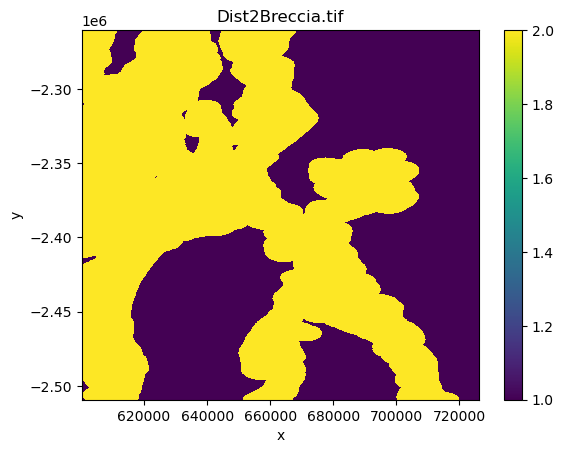

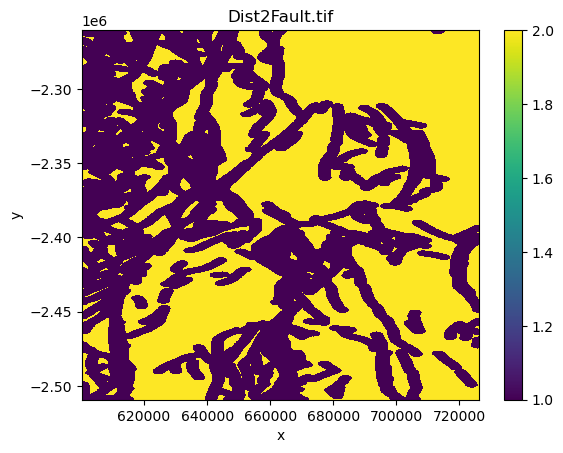

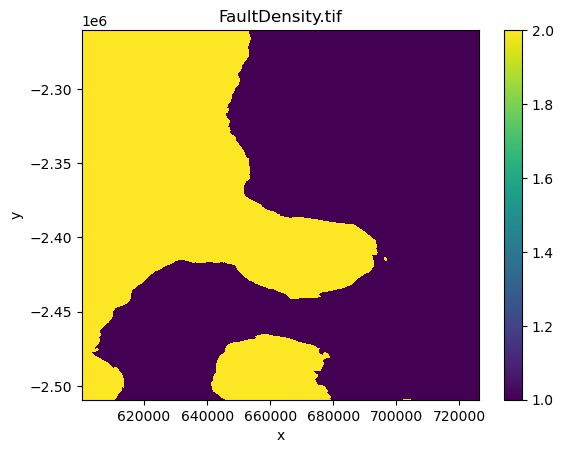

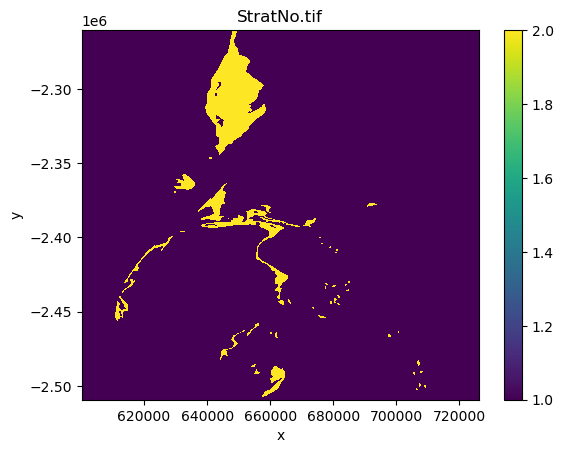

In [345]:
for r in response:
    fig, ax = plt.subplots()
    response[r].plot(ax=ax)
    plt.title(r)

In [346]:
#above maps should be class split on response proruce in calculation of weights
for r in response:
    print(response[r].rio.bounds(), response[r].rio.crs, response[r].rio.resolution(), response[r].rio.nodata, response[r].dtype, r)

(600261.7688999996, -2509191.0156999994, 726161.7688999996, -2260491.0156999994) EPSG:7845 (100.0, -100.0) nan float32 Dist2Breccia.tif
(600261.7688999996, -2509191.0156999994, 726161.7688999996, -2260491.0156999994) EPSG:7845 (100.0, -100.0) nan float32 Dist2Fault.tif
(600261.7688999996, -2509191.0156999994, 726161.7688999996, -2260491.0156999994) EPSG:7845 (100.0, -100.0) nan float32 FaultDensity.tif
(600261.7688999996, -2509191.0156999994, 726161.7688999996, -2260491.0156999994) EPSG:7845 (100.0, -100.0) nan float32 StratNo.tif


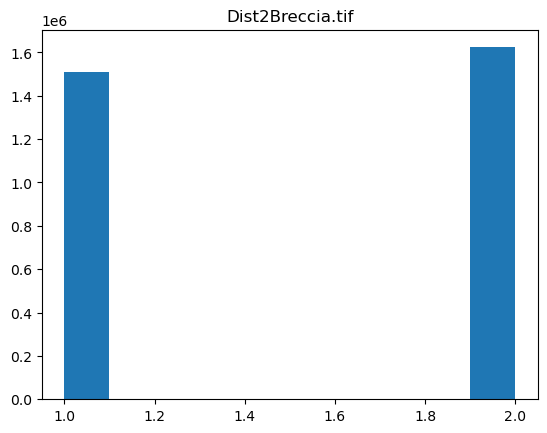

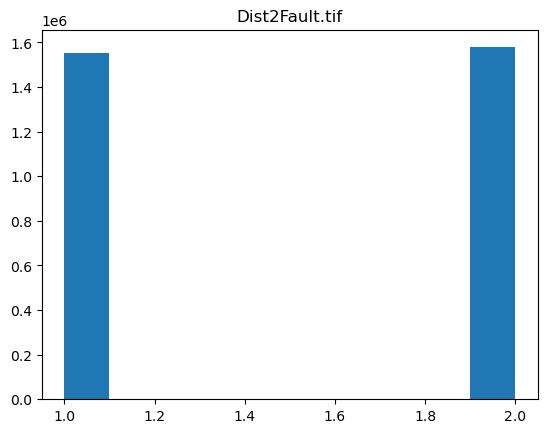

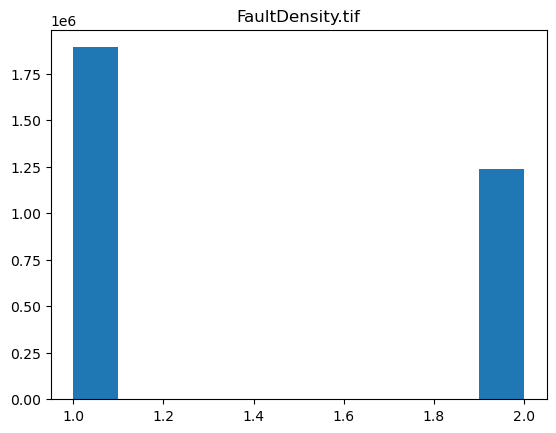

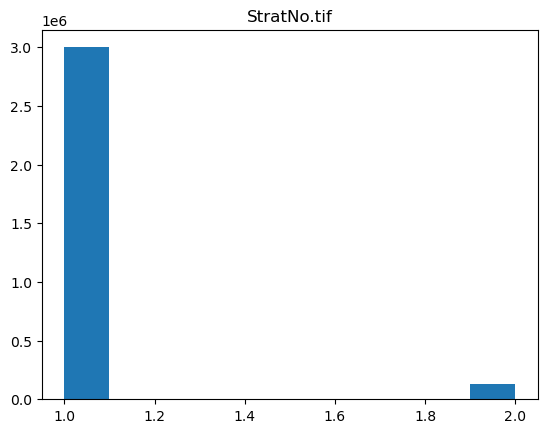

In [347]:
for r in response:
    fig, ax = plt.subplots()
    xr.plot.hist(response[r])
    plt.title(r)

In [88]:
ds = xr.Dataset()

for index, d in enumerate(data.keys()):

    dc = dataclass[index]
    
    if dc != 'c':
        class2 = makeWts[d].loc[makeWts[d]['GEN_CLASS'] == 2]['CLASS'].values.tolist()
        print(len(class2))
        
        da = data[d].where(data[d].isin(class2), other = 1)
        da = da.where(~da.isin(class2), other = 2)
        
        ds[d] = da
        
    else:
        class2 = makeWts[d].loc[makeWts[d]['WEIGHT'] > 1.0]['CLASS'].values.tolist()  #made up rule of thumb for this example
        print(len(class2))
        
        da = data[d].where(data[d].isin(class2), other = 1)
        da = da.where(~da.isin(class2), other = 2)
        
        ds[d] = da


344
95
2
7


In [89]:
ds

<xarray.Dataset>
Dimensions:           (band: 1, x: 1259, y: 2487)
Coordinates:
  * band              (band) int32 1
  * x                 (x) float64 6.003e+05 6.004e+05 ... 7.26e+05 7.261e+05
  * y                 (y) float64 -2.261e+06 -2.261e+06 ... -2.509e+06
    spatial_ref       int32 0
Data variables:
    Dist2Breccia.tif  (band, y, x) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    Dist2Fault.tif    (band, y, x) float64 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0
    FaultDensity.tif  (band, y, x) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    StratNo.tif       (band, y, x) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0

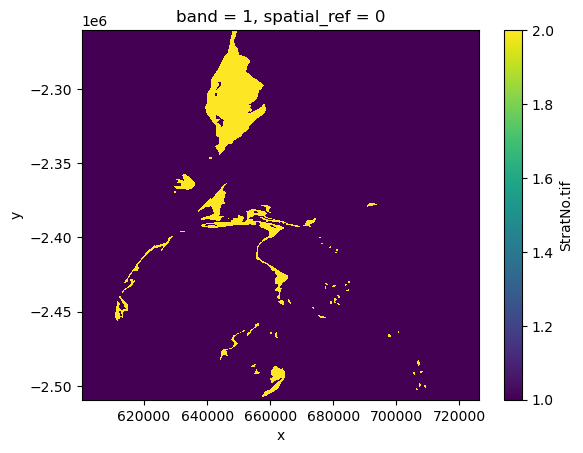

In [90]:
ds['StratNo.tif'].plot()

In [73]:
makeWts[d].shape

(87, 34)

In [74]:
makeWts[d]

,CLASS,CLASS_AREA,AREA_SQ_KM,AREA_UNITS,NO_POINTS,WPLUS,S_WPLUS,WMINUS,S_WMINUS,CONTRAST,S_CONTRAST,STUDC,GEN_CLASS,WEIGHT,W_STD,s,b,ds,db,priorprob,pbd,pbdb,ls,wp,vp,sp,pbbd,pbbdb,ln1,wm,vm,sm,c,sc
0,585.0,997.14,997.14,997.14,16.0,0.674375,0.252030,-0.031917,0.064541,0.706292,0.260163,2.714806,NaN,NaN,NaN,31311.33,997.14,258,16.0,0.00824,0.062016,0.031595,1.962806,0.674375,0.063519,0.252030,0.937984,0.968405,0.968587,-0.031917,0.004166,0.064541,0.706292,0.260163
1,1621.0,101.41,101.41,101.41,0.0,-inf,inf,0.003271,0.062516,-inf,inf,NaN,NaN,NaN,NaN,31311.33,101.41,258,0.0,0.00824,0.000000,0.003266,0.000000,-inf,inf,inf,1.000000,0.996734,1.003276,0.003271,0.003908,0.062516,-inf,inf
2,4727.0,3443.14,3443.14,3443.14,59.0,0.741184,0.131319,-0.144268,0.071144,0.885452,0.149352,5.928620,NaN,NaN,NaN,31311.33,3443.14,258,59.0,0.00824,0.228682,0.108978,2.098419,0.741184,0.017245,0.131319,0.771318,0.891022,0.865656,-0.144268,0.005061,0.071144,0.885452,0.149352
3,6432.0,17.47,17.47,17.47,0.0,-inf,inf,0.000563,0.062516,-inf,inf,NaN,NaN,NaN,NaN,31311.33,17.47,258,0.0,0.00824,0.000000,0.000563,0.000000,-inf,inf,inf,1.000000,0.999437,1.000563,0.000563,0.003908,0.062516,-inf,inf
4,7245.0,60.89,60.89,60.89,2.0,1.407978,0.719014,-0.005884,0.062758,1.413862,0.721747,1.958942,NaN,NaN,NaN,31311.33,60.89,258,2.0,0.00824,0.007752,0.001896,4.087680,1.407978,0.516981,0.719014,0.992248,0.998104,0.994133,-0.005884,0.003939,0.062758,1.413862,0.721747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,81280.0,4.83,4.83,4.83,0.0,-inf,inf,0.000156,0.062515,-inf,inf,NaN,NaN,NaN,NaN,31311.33,4.83,258,0.0,0.00824,0.000000,0.000156,0.000000,-inf,inf,inf,1.000000,0.999844,1.000156,0.000156,0.003908,0.062515,-inf,inf
83,81284.0,27.10,27.10,27.10,0.0,-inf,inf,0.000873,0.062516,-inf,inf,NaN,NaN,NaN,NaN,31311.33,27.10,258,0.0,0.00824,0.000000,0.000873,0.000000,-inf,inf,inf,1.000000,0.999127,1.000873,0.000873,0.003908,0.062516,-inf,inf
84,81639.0,46.65,46.65,46.65,0.0,-inf,inf,0.001503,0.062516,-inf,inf,NaN,NaN,NaN,NaN,31311.33,46.65,258,0.0,0.00824,0.000000,0.001502,0.000000,-inf,inf,inf,1.000000,0.998498,1.001505,0.001503,0.003908,0.062516,-inf,inf
85,81640.0,141.26,141.26,141.26,0.0,-inf,inf,0.004559,0.062517,-inf,inf,NaN,NaN,NaN,NaN,31311.33,141.26,258,0.0,0.00824,0.000000,0.004549,0.000000,-inf,inf,inf,1.000000,0.995451,1.004570,0.004559,0.003908,0.062517,-inf,inf


In [58]:
makeWts[d].groupby('GEN_CLASS').sum().reset_index()

C:\Users\rscott\AppData\Local\Temp\ipykernel_18472\2909909710.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  makeWts[d].groupby('GEN_CLASS').sum().reset_index()


,GEN_CLASS,CLASS,CLASS_AREA,AREA_SQ_KM,AREA_UNITS,NO_POINTS,WPLUS,S_WPLUS,WMINUS,S_WMINUS,CONTRAST,S_CONTRAST,STUDC,s,b,ds,db,priorprob,pbd,pbdb,ls,wp,vp,sp,pbbd,pbbdb,ln1,wm,vm,sm,c,sc
0,1,14386300.0,1656.11,8985998.44,8985998.44,75586.0,5.022568,18.353574,-352.905135,294.264885,357.927703,294.836968,355.646665,9174219.69,8985998.44,75594,75303.85,2.414270,291.875388,286.948118,298.100694,5.022568,1.149671,18.353574,1.124612,6.051882,638.217091,-352.905135,295.654133,294.264885,357.927703,294.836968
1,2,5934000.0,29653.75,8030235.34,8030235.34,78597.0,70.789382,23.046988,-336.423687,89.587964,407.213070,93.418388,1766.267857,10771097.52,8030235.34,88752,78597.00,2.834501,304.639535,256.063950,429.300610,70.789382,1.553742,23.046988,39.360465,87.936050,133.200942,-336.423687,28.774532,89.587964,407.213070,93.418388


In [59]:
makeWts[d]

,CLASS,CLASS_AREA,AREA_SQ_KM,AREA_UNITS,NO_POINTS,WPLUS,S_WPLUS,WMINUS,S_WMINUS,CONTRAST,S_CONTRAST,STUDC,GEN_CLASS,WEIGHT,W_STD,s,b,ds,db,priorprob,pbd,pbdb,ls,wp,vp,sp,pbbd,pbbdb,ln1,wm,vm,sm,c,sc
0,100.0,6370.30,6370.30,6370.30,103.0,0.682130,0.099339,-0.284109,0.080575,0.966238,0.127909,7.554136,2,0.050938,0.06265,31311.33,6370.30,258,103.00,0.00824,0.399225,0.201824,1.978086,0.682130,0.009868,0.099339,0.600775,0.798176,0.752685,-0.284109,0.006492,0.080575,0.966238,0.127909
1,200.0,443.11,6813.41,6813.41,116.0,0.734616,0.093648,-0.354201,0.084165,1.088817,0.125912,8.647480,2,0.050938,0.06265,31311.33,6813.41,258,116.00,0.00824,0.449612,0.215674,2.084681,0.734616,0.008770,0.093648,0.550388,0.784326,0.701734,-0.354201,0.007084,0.084165,1.088817,0.125912
2,300.0,471.27,7284.68,7284.68,122.0,0.717883,0.091304,-0.378086,0.085996,1.095969,0.125426,8.738006,2,0.050938,0.06265,31311.33,7284.68,258,122.00,0.00824,0.472868,0.230657,2.050089,0.717883,0.008336,0.091304,0.527132,0.769343,0.685172,-0.378086,0.007395,0.085996,1.095969,0.125426
3,400.0,395.71,7680.39,7680.39,128.0,0.712913,0.089134,-0.406760,0.087951,1.119672,0.125221,8.941586,2,0.050938,0.06265,31311.33,7680.39,258,128.00,0.00824,0.496124,0.243207,2.039924,0.712913,0.007945,0.089134,0.503876,0.756793,0.665804,-0.406760,0.007735,0.087951,1.119672,0.125221
4,500.0,444.27,8124.66,8124.66,135.0,0.709873,0.086790,-0.443328,0.090410,1.153201,0.125326,9.201634,2,0.050938,0.06265,31311.33,8124.66,258,135.00,0.00824,0.523256,0.257288,2.033733,0.709873,0.007533,0.086790,0.476744,0.742712,0.641897,-0.443328,0.008174,0.090410,1.153201,0.125326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,63800.0,0.58,31310.44,31310.44,258.0,-0.003848,0.062635,NaN,1.004070,NaN,1.006021,NaN,NaN,NaN,NaN,31311.33,31310.44,258,257.01,0.00824,0.996163,1.000003,0.996160,-0.003848,0.003923,0.062635,0.003837,-0.000003,-1191.581267,NaN,1.008156,1.004070,NaN,1.006021
638,63900.0,0.43,31310.87,31310.87,258.0,-0.003862,0.062635,NaN,1.004070,NaN,1.006022,NaN,NaN,NaN,NaN,31311.33,31310.87,258,257.01,0.00824,0.996163,1.000017,0.996146,-0.003862,0.003923,0.062635,0.003837,-0.000017,-224.826654,NaN,1.008158,1.004070,NaN,1.006022
639,64000.0,0.28,31311.15,31311.15,258.0,-0.003871,0.062635,NaN,1.004071,NaN,1.006023,NaN,NaN,NaN,NaN,31311.33,31311.15,258,257.01,0.00824,0.996163,1.000026,0.996137,-0.003871,0.003923,0.062635,0.003837,-0.000026,-147.108798,NaN,1.008159,1.004071,NaN,1.006023
640,64100.0,0.15,31311.30,31311.30,258.0,-0.003876,0.062635,NaN,1.004071,NaN,1.006023,NaN,NaN,NaN,NaN,31311.33,31311.30,258,257.01,0.00824,0.996163,1.000031,0.996132,-0.003876,0.003923,0.062635,0.003837,-0.000031,-124.123049,NaN,1.008159,1.004071,NaN,1.006023


In [60]:
freqTable2[d]

,group,spatial_ref,count,value,n
0,100.0,0,637030,100.0,103.0
1,200.0,0,44311,200.0,13.0
2,300.0,0,47127,300.0,6.0
3,400.0,0,39571,400.0,6.0
4,500.0,0,44427,500.0,7.0
...,...,...,...,...,...
637,63800.0,0,58,0.0,0.0
638,63900.0,0,43,0.0,0.0
639,64000.0,0,28,0.0,0.0
640,64100.0,0,15,0.0,0.0


In [120]:
## going to use multiple times - want a function version
## generalise deposits from deposits
## assume data reading done outside for now
# pixel size in km

unitArea = 1
confCont = 2 ## user supplied

class_km2 = [data[d].rio.resolution()[0] / 1000, abs(data[d].rio.resolution()[1] / 1000)]  #pos y value
class_km2

dataclass = ['a','a','d','c']  ## definited types in order for each raster

def calculate_weights(data, deposits, unitArea, confCont, class_km2, dataclass):
    """
    data : dictionary of rasters, xarray dataset would work too
    deposits : geodataframe of deposit info - assumes for now has a column called deposit
    unitArea : in km squared for this version
    confCont : cutoff value - suggested range 0.5 to 2
    class_km2 : x/y resolution from raster
    dataclass : raster type, ascending, descending, categorical [final binary versions are this]
    
    """
    colnames = ["CLASS", "CLASS_AREA", "AREA_SQ_KM", "AREA_UNITS", "NO_POINTS", "WPLUS", "S_WPLUS", "WMINUS", "S_WMINUS",\
                "CONTRAST", "S_CONTRAST", "STUDC", "GEN_CLASS", "WEIGHT", "W_STD"]
    
    freqTable = {}
    depSig = {}
    valCount = {}
    valCount2 = {}
    freqTable2 = {}
    freqTableD = {}
    makeWts = {}
    
    for index, d in enumerate(data):
        freqTable[d] = data[d].groupby(data[d]).count()
        freqTable[d] = freqTable[d].to_dataframe()
        freqTable[d].columns = ['spatial_ref','count']
        freqTable[d] = freqTable[d].reset_index()   
        
        depSig[d] = location_sample(deposits, data[d], 'Deposit')    

        #print(depSig[d])
        
        #valCount[d] = freqTable[d].merge(depSig[d], left_on="group",right_on="group")    
        valCount[d] = freqTable[d].merge(depSig[d], left_on=data[d].name,right_on=data[d].name)    
        
        #gb = valCount[d].groupby('group').count().reset_index()
        gb = valCount[d].groupby(data[d].name).count().reset_index()
        
        #gb = gb[['group','count']]
        gb = gb[[data[d].name,'count']]
        gb.columns = ['value','n']
        valCount2[d] = gb    
        
        #print(valCount2[d])
        
        #freqTable2[d] = freqTable[d].merge(valCount2[d], left_on="group",right_on="value", how="left")
        freqTable2[d] = freqTable[d].merge(valCount2[d], left_on=data[d].name,right_on="value", how="left")
        freqTable2[d].fillna(0, inplace=True)

        #freqTableD[d] = freqTable2[d].sort_values(by='group',ascending=False)        
        freqTableD[d] = freqTable2[d].sort_values(by=data[d].name,ascending=False)        
        
        makeWts[d] = pd.DataFrame(columns=colnames)        
        
        dc = dataclass[index]

        print(d, dc)

        if dc != 'c':
            if dc == 'd': ## doing the decending versions - bigger data better  . e.g. freqTableD
                #makeWts[d]['CLASS'] = freqTableD[d]['group']
                makeWts[d]['CLASS'] = freqTableD[d][data[d].name]
                
                makeWts[d]['CLASS_AREA'] = freqTableD[d]['count'] * class_km2[0]  * class_km2[1]
                makeWts[d]['AREA_SQ_KM'] = freqTableD[d]['count'] * class_km2[0]  * class_km2[1]                                                         
                makeWts[d]['AREA_UNITS'] = freqTableD[d]['count'] * class_km2[0]  * unitArea
                makeWts[d]['NO_POINTS'] = freqTableD[d]['n']

                makeWts[d]['AREA_SQ_KM'] = makeWts[d]['AREA_SQ_KM'].cumsum()
                makeWts[d]['AREA_UNITS'] = makeWts[d]['AREA_SQ_KM'] * unitArea
                makeWts[d]['NO_POINTS'] = makeWts[d]['NO_POINTS'].cumsum()

            if dc == 'a': ## doing the ascending versions - smaller data 'better'

                #makeWts[d]['CLASS'] = freqTable2[d]['group']
                makeWts[d]['CLASS'] = freqTable2[d][data[d].name]
                
                makeWts[d]['CLASS_AREA'] = freqTable2[d]['count'] * class_km2[0]  * class_km2[1]
                makeWts[d]['AREA_SQ_KM'] = freqTable2[d]['count'] * class_km2[0]  * class_km2[1]                                                         
                makeWts[d]['AREA_UNITS'] = freqTable2[d]['count'] * class_km2[0]  * unitArea
                makeWts[d]['NO_POINTS'] = freqTable2[d]['n']

                makeWts[d]['AREA_SQ_KM'] = makeWts[d]['AREA_SQ_KM'].cumsum()
                makeWts[d]['AREA_UNITS'] = makeWts[d]['AREA_SQ_KM'] * unitArea
                makeWts[d]['NO_POINTS'] = makeWts[d]['NO_POINTS'].cumsum()


            makeWts[d]['s'] = makeWts[d]['AREA_UNITS'].max()
            makeWts[d]['b'] = makeWts[d]['AREA_UNITS']
            makeWts[d]['ds'] = deposits.shape[0]
            makeWts[d]['db'] = makeWts[d]['NO_POINTS']

            makeWts[d]['priorprob'] = makeWts[d]['ds'] / makeWts[d]['s']

            for c in ["WPLUS", "S_WPLUS", "WMINUS", "S_WMINUS", "CONTRAST", "S_CONTRAST", "STUDC"]:
                makeWts[d].loc[makeWts[d]['db'] == 0, c] = 0

            makeWts[d].loc[makeWts[d]['db'] == makeWts[d]['ds'], 'db'] = makeWts[d]['db'] - 0.99

            makeWts[d].loc[(makeWts[d]['s'] - makeWts[d]['db']) <= (makeWts[d]['ds'] - makeWts[d]['db']), 'b'] \
                = makeWts[d]['s'] + makeWts[d]['db'] - makeWts[d]['ds'] - 0.99

            makeWts[d].loc[(makeWts[d]['b'] - makeWts[d]['db']) <= 0.0, 'b'] = makeWts[d]['db'] + 1

            makeWts[d]['pbd'] = makeWts[d]['db'] / makeWts[d]['ds']
            makeWts[d]['pbdb'] = (makeWts[d]['b'] - makeWts[d]['db']) / (makeWts[d]['s'] - makeWts[d]['ds'])
            makeWts[d]['ls'] = makeWts[d]['pbd'] / makeWts[d]['pbdb']
            makeWts[d]['wp'] = np.log(makeWts[d]['ls'])
            makeWts[d]['WPLUS'] = makeWts[d]['wp']    

            makeWts[d]['vp'] = (1.0 / makeWts[d]['db']) + (1.0 / (makeWts[d]['b'] - makeWts[d]['db']) )
            makeWts[d]['sp'] = np.sqrt(makeWts[d]['vp'])          
            makeWts[d]['S_WPLUS'] = makeWts[d]['sp']    

            makeWts[d]['pbbd'] = (makeWts[d]['ds'] - makeWts[d]['db']) / makeWts[d]['ds']
            makeWts[d]['pbbdb'] = (makeWts[d]['s'] - makeWts[d]['b'] - makeWts[d]['ds'] + makeWts[d]['db']) / (makeWts[d]['s'] - makeWts[d]['ds'])
            makeWts[d]['ln1'] = makeWts[d]['pbbd'] / makeWts[d]['pbbdb']
            makeWts[d]['wm'] = np.log(makeWts[d]['ln1'])
            makeWts[d]['WMINUS'] = makeWts[d]['wm']    

            makeWts[d]['vm'] = (1.0 / (makeWts[d]['ds'] - makeWts[d]['db'])) + (1.0 / (makeWts[d]['s'] - makeWts[d]['b']  - makeWts[d]['ds'] +- makeWts[d]['db']) ) 
            makeWts[d]['sm'] = np.sqrt(makeWts[d]['vm'])          
            makeWts[d]['S_WMINUS'] = makeWts[d]['sm']    

            makeWts[d]['c'] = makeWts[d]['wp'] - makeWts[d]['wm']
            makeWts[d]['CONTRAST'] = makeWts[d]['c']

            makeWts[d]['sc'] = np.sqrt(makeWts[d]['vp'] + makeWts[d]['vm'])
            makeWts[d]['S_CONTRAST'] = makeWts[d]['sc']
            makeWts[d]['STUDC'] = makeWts[d]['c'] / makeWts[d]['sc']    

            maxConf = makeWts[d]['STUDC'].idxmax()
            maxCont = makeWts[d]['CONTRAST'].idxmax()

            if maxConf < confCont:
                makeWts[d]['GEN_CLASS'] = 999
                makeWts[d]['WEIGHT'] = 0.0
                makeWts[d]['W_STD'] = 0.0
            else:
                makeWts[d].loc[(makeWts[d]['CLASS'] <= makeWts[d]['CLASS'].max()) & (makeWts[d]['CONTRAST'] <= makeWts[d]['CONTRAST'].max()) \
                              & (makeWts[d]['STUDC'] <= makeWts[d]['STUDC'].max()) & (makeWts[d].index <= maxCont)\
                              , ['GEN_CLASS','WEIGHT','W_STD']]  = [2, makeWts[d].iloc[maxCont]['WPLUS'], makeWts[d].iloc[maxCont]['S_WPLUS']]

                makeWts[d].loc[(makeWts[d]['CLASS'] <= makeWts[d]['CLASS'].max()) & (makeWts[d]['CONTRAST'] <= makeWts[d]['CONTRAST'].max()) \
                              & (makeWts[d]['STUDC'] <= makeWts[d]['STUDC'].max()) & (makeWts[d].index > maxCont)\
                              , ['GEN_CLASS','WEIGHT','W_STD']]  = [1, makeWts[d].iloc[maxCont]['WMINUS'], makeWts[d].iloc[maxCont]['S_WMINUS']]


        if dc == 'c':
            #makeWts[d]['CLASS'] = freqTable2[d]['group']
            makeWts[d]['CLASS'] = freqTable2[d][data[d].name]
            
            
            makeWts[d]['CLASS_AREA'] = freqTable2[d]['count'] * class_km2[0]  * class_km2[1]
            makeWts[d]['AREA_SQ_KM'] = freqTable2[d]['count'] * class_km2[0]  * class_km2[1]                                                         
            makeWts[d]['AREA_UNITS'] = freqTable2[d]['count'] * class_km2[0]  * class_km2[1] * unitArea
            makeWts[d]['NO_POINTS'] = freqTable2[d]['n']

            makeWts[d]['s'] = makeWts[d]['AREA_UNITS'].sum()
            makeWts[d]['b'] = makeWts[d]['AREA_UNITS']
            makeWts[d]['ds'] = deposits.shape[0]
            makeWts[d]['db'] = makeWts[d]['NO_POINTS']

            makeWts[d]['priorprob'] = makeWts[d]['ds'] / makeWts[d]['s']

            for c in ["WPLUS", "S_WPLUS", "WMINUS", "S_WMINUS", "CONTRAST", "S_CONTRAST", "STUDC"]:
                makeWts[d].loc[makeWts[d]['db'] == 0, c] = 0

            makeWts[d].loc[makeWts[d]['db'] == makeWts[d]['ds'], 'db'] = makeWts[d]['db'] - 0.99

            makeWts[d].loc[makeWts[d]['db'] == 0.001, 'db'] = makeWts[d]['ds'] - 0.99

            makeWts[d].loc[(makeWts[d]['s'] - makeWts[d]['db']) <= (makeWts[d]['ds'] - makeWts[d]['db']), 'b'] \
                = makeWts[d]['s'] + makeWts[d]['db'] - makeWts[d]['ds'] - 0.99

            makeWts[d].loc[(makeWts[d]['b'] - makeWts[d]['db']) <= 0.0, 'b'] = makeWts[d]['db'] + 1

            makeWts[d]['pbd'] = makeWts[d]['db'] / makeWts[d]['ds']
            makeWts[d]['pbdb'] = (makeWts[d]['b'] - makeWts[d]['db']) / (makeWts[d]['s'] - makeWts[d]['ds'])
            makeWts[d]['ls'] = makeWts[d]['pbd'] / makeWts[d]['pbdb']
            makeWts[d]['wp'] = np.log(makeWts[d]['ls'])
            makeWts[d]['WPLUS'] = makeWts[d]['wp']    

            makeWts[d]['vp'] = (1.0 / makeWts[d]['db']) + (1.0 / (makeWts[d]['b'] - makeWts[d]['db']) )
            makeWts[d]['sp'] = np.sqrt(makeWts[d]['vp'])          
            makeWts[d]['S_WPLUS'] = makeWts[d]['sp']    

            makeWts[d]['pbbd'] = (makeWts[d]['ds'] - makeWts[d]['db']) / makeWts[d]['ds']
            makeWts[d]['pbbdb'] = (makeWts[d]['s'] - makeWts[d]['b'] - makeWts[d]['ds'] + makeWts[d]['db']) / (makeWts[d]['s'] - makeWts[d]['ds'])
            makeWts[d]['ln1'] = makeWts[d]['pbbd'] / makeWts[d]['pbbdb']
            makeWts[d]['wm'] = np.log(makeWts[d]['ln1'])
            makeWts[d]['WMINUS'] = makeWts[d]['wm']    

            makeWts[d]['vm'] = (1.0 / (makeWts[d]['ds'] - makeWts[d]['db'])) + (1.0 / (makeWts[d]['s'] - makeWts[d]['b']  - makeWts[d]['ds'] +- makeWts[d]['db']) ) 
            makeWts[d]['sm'] = np.sqrt(makeWts[d]['vm'])          
            makeWts[d]['S_WMINUS'] = makeWts[d]['sm']    

            makeWts[d]['c'] = makeWts[d]['wp'] - makeWts[d]['wm']
            makeWts[d]['CONTRAST'] = makeWts[d]['c']

            makeWts[d]['sc'] = np.sqrt(makeWts[d]['vp'] + makeWts[d]['vm'])
            makeWts[d]['S_CONTRAST'] = makeWts[d]['sc']
            makeWts[d]['STUDC'] = makeWts[d]['c'] / makeWts[d]['sc']    

            maxConf = makeWts[d]['STUDC'].idxmax()
            maxCont = makeWts[d]['CONTRAST'].idxmax()

            if maxConf < confCont:
                makeWts[d]['GEN_CLASS'] = 999
                makeWts[d]['WEIGHT'] = 0.0
                makeWts[d]['W_STD'] = 0.0

            makeWts[d].loc[makeWts[d]['STUDC'] >= confCont, ['GEN_CLASS','WEIGHT','W_STD']] \
            =  makeWts[d].loc[ makeWts[d]['STUDC'] >= confCont][['CLASS','WPLUS','S_WPLUS']].to_numpy()

            makeWts[d].loc[(makeWts[d]['STUDC'] < confCont) & (maxConf >= confCont), ['GEN_CLASS','WEIGHT','W_STD']] \
            =  makeWts[d].loc[ (makeWts[d]['STUDC'] < confCont) & (maxConf >= confCont)][['CLASS','WPLUS','S_WPLUS']].to_numpy()
    
    return makeWts


In [115]:
testWts = calculate_weights(data, iocg, unitArea, confCont, class_km2, dataclass)
testWts    

      value    n
0     100.0  103
1     200.0   13
2     300.0    6
3     400.0    6
4     500.0    7
..      ...  ...
84  32800.0    1
85  33700.0    1
86  34000.0    1
87  34400.0    2
88  35300.0    1

[89 rows x 2 columns]
Dist2Breccia.tif a


C:\Users\rscott\AppData\Local\miniconda3\envs\pangeo\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     value   n
0    100.0  25
1    200.0  29
2    300.0  16
3    400.0  16
4    500.0  10
5    600.0  13
6    700.0   4
7    800.0   6
8    900.0   4
9   1000.0   5
10  1100.0   8
11  1200.0   5
12  1300.0   7
13  1400.0   5
14  1500.0   3
15  1600.0   6
16  1700.0   8
17  1800.0   5
18  1900.0  11
19  2000.0   9
20  2100.0   2
21  2200.0   2
22  2300.0   1
23  2400.0   2
24  2500.0   2
25  2600.0   2
26  2700.0   3
27  2900.0   2
28  3000.0   2
29  3100.0   1
30  3200.0   1
31  3300.0   3
32  3400.0   2
33  3600.0   1
34  3700.0   1
35  3800.0   4
36  3900.0   1
37  4000.0   2
38  4100.0   2
39  4200.0   2
40  4300.0   1
41  4500.0   2
42  4600.0   1
43  4700.0   1
44  4800.0   2
45  4900.0   1
46  5000.0   1
47  5100.0   1
48  5200.0   1
49  5300.0   3
50  5700.0   1
51  5800.0   1
52  6400.0   2
53  6600.0   1
54  6800.0   1
55  7400.0   1
56  7800.0   1
57  8000.0   1
58  9500.0   1
59  9700.0   1
Dist2Fault.tif a


C:\Users\rscott\AppData\Local\miniconda3\envs\pangeo\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


   value   n
0    3.0  20
1    4.0  27
2    5.0  24
3    6.0  52
4    7.0  73
5    8.0  40
6    9.0  17
7   10.0   5
FaultDensity.tif d


C:\Users\rscott\AppData\Local\miniconda3\envs\pangeo\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


      value   n
0     585.0  16
1    4727.0  59
2    7245.0   2
3    9919.0  18
4   11361.0   1
5   12754.0   1
6   12978.0   8
7   17306.0  26
8   18370.0  16
9   24253.0   1
10  26091.0   6
11  27185.0   1
12  27187.0  19
13  27702.0   5
14  27935.0   2
15  28675.0   6
16  30704.0   1
17  30727.0   2
18  31420.0   6
19  31441.0   4
20  40535.0   3
21  42515.0  22
22  76890.0   4
23  79890.0   5
24  79899.0   3
25  79907.0   9
26  79912.0   1
27  79914.0   5
28  79926.0   1
29  79985.0   5
StratNo.tif c


C:\Users\rscott\AppData\Local\miniconda3\envs\pangeo\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


{'Dist2Breccia.tif':        CLASS  CLASS_AREA  AREA_SQ_KM  AREA_UNITS  NO_POINTS     WPLUS  \
 0      100.0     6370.30     6370.30     6370.30      103.0  0.682130   
 1      200.0      443.11     6813.41     6813.41      116.0  0.734616   
 2      300.0      471.27     7284.68     7284.68      122.0  0.717883   
 3      400.0      395.71     7680.39     7680.39      128.0  0.712913   
 4      500.0      444.27     8124.66     8124.66      135.0  0.709873   
 ..       ...         ...         ...         ...        ...       ...   
 637  63800.0        0.58    31310.44    31310.44      258.0 -0.003848   
 638  63900.0        0.43    31310.87    31310.87      258.0 -0.003862   
 639  64000.0        0.28    31311.15    31311.15      258.0 -0.003871   
 640  64100.0        0.15    31311.30    31311.30      258.0 -0.003876   
 641  64200.0        0.03    31311.33    31311.33      258.0 -0.003876   
 
       S_WPLUS    WMINUS  S_WMINUS  CONTRAST  S_CONTRAST     STUDC GEN_CLASS  \
 0    0.09

In [121]:
binaryclass = ['c','c','c','c']

#binaryWts = calculate_weights(binary, iocg, unitArea, confCont, class_km2, binaryclass)
binaryWts = calculate_weights(ds, iocg, unitArea, confCont, class_km2, binaryclass)
binaryWts    

Dist2Breccia.tif c
Dist2Fault.tif c
FaultDensity.tif c
StratNo.tif c


{'Dist2Breccia.tif':    CLASS  CLASS_AREA  AREA_SQ_KM  AREA_UNITS  NO_POINTS     WPLUS   S_WPLUS  \
 0    1.0     1657.58     1657.58     1657.58          1 -2.622009  1.000302   
 1    2.0    29653.75    29653.75    29653.75        257  0.050938  0.062650   
 
      WMINUS  S_WMINUS  CONTRAST  S_CONTRAST     STUDC  GEN_CLASS    WEIGHT  \
 0  0.050938  0.062650 -2.672947    1.002262 -2.666915      999.0  0.000000   
 1 -2.622009  1.000438  2.672947    1.002397  2.666555        2.0  0.050938   
 
      W_STD         s         b   ds   db  priorprob       pbd      pbdb  \
 0  0.00000  31311.33   1657.58  258    1    0.00824  0.003876  0.053346   
 1  0.06265  31311.33  29653.75  258  257    0.00824  0.996124  0.946654   
 
          ls        wp        vp        sp      pbbd     pbbdb       ln1  \
 0  0.072657 -2.622009  1.000604  1.000302  0.996124  0.946654  1.052258   
 1  1.052258  0.050938  0.003925  0.062650  0.003876  0.053346  0.072657   
 
          wm        vm        sm       

In [126]:
mapNo = len(data)  #number of rasters
missData = -1

In [136]:
ds[d].name

'Dist2Breccia.tif'

In [170]:
# build Response - should make a function

rfreqTable = {}
csvRast = {}

for index, d in enumerate(ds):
    rfreqTable[d] = ds[d].groupby(ds[d]).count()
    rfreqTable[d] = rfreqTable[d].to_dataframe()
    rfreqTable[d].columns = ['spatial_ref','count']
    rfreqTable[d] = rfreqTable[d].reset_index()   
    
    csvRast[d] = rfreqTable[d].merge(binaryWts[d], left_on=ds[d].name,right_on="CLASS")    
    
    csvRast[d]['s'] = csvRast[d]['AREA_UNITS'].sum()
    csvRast[d]['ds'] = iocg.shape[0]
    csvRast[d]['prior_prob'] = csvRast[d]['ds'] / csvRast[d]['s']
    csvRast[d]['prior_logit'] = np.log(csvRast[d]['prior_prob'] / (1.0 - csvRast[d]['prior_prob']) )
    csvRast[d]['wstd_const'] = 1.0 / csvRast[d]['ds']
    
    calcW = ds[d].where(ds[d] == csvRast[d].iloc[0]['CLASS'], other = csvRast[d].iloc[1]['WEIGHT'])
    calcW = calcW.where(calcW == csvRast[d].iloc[1]['WEIGHT'], other = csvRast[d].iloc[0]['WEIGHT'])  
    
    calcWSTD = ds[d].where(ds[d] == csvRast[d].iloc[0]['CLASS'], other = csvRast[d].iloc[1]['W_STD'])
    calcWSTD = calcW.where(calcW == csvRast[d].iloc[1]['WEIGHT'], other = csvRast[d].iloc[0]['W_STD'])  
    
    if index == 0:  #first map
        postlogit = calcW + csvRast[d]['prior_logit'].max()
        sumWSTD = calcWSTD * calcWSTD + csvRast[d]['wstd_const'].max()
    else:
        postlogit = postlogit + calcW
        sumWSTD = sumWSTD + calcWSTD * calcWSTD
    
postodds = np.exp(postlogit)        
postprob = postodds / (1 + postodds)
pprb_std = np.sqrt(postprob * postprob) * sumWSTD
pprb_conf = postprob / pprb_std


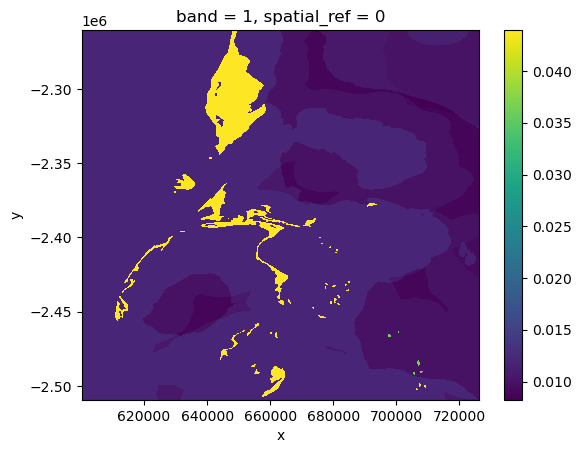

In [173]:
postprob.plot()

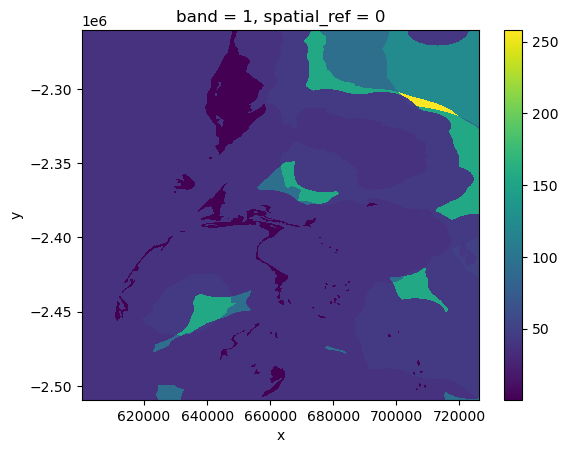

In [171]:
pprb_conf.plot()

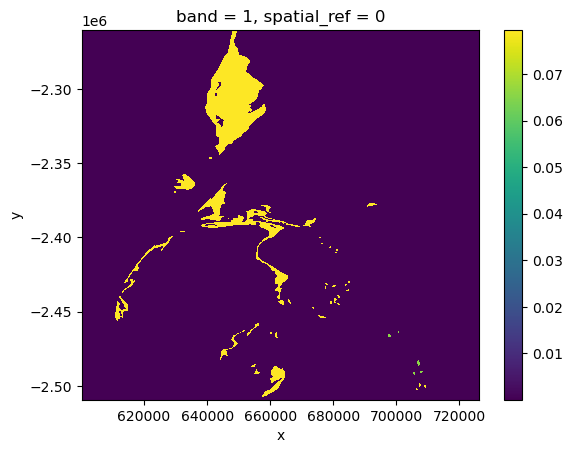

In [172]:
pprb_std.plot()

In [174]:
def plotmap(da, robust=False, cmap='cetrainbow', size=6, title='Title Here', clip=None, savefig=True, slide_dict=None, background=False):
    """
    Plot a dataarray with a title.
    Allow saving to a png
    Allow adding to a dictionary e.g. for presentation use

    Args:
        da: A DataArray
        robust: clip to 2/98 or not
        cmap: a matplotlib colormap
        size: integer size of plot
        title: string title of plot
        clip: quantile number to clip to
        savefig: save png to directory
        slide_dict: add png path to a dictionary
        background: plot a background shape layer

    Returns:
        The squarest root.

    Examples:
    
    """

    fig, ax = plt.subplots(figsize=(size,size))
    if background is False:
        pass
    elif background is True:
        daback = da / da
        da.plot(cmap='Greys')
    
    else:
        background.plot()
        
    if clip is not None:
        quantile = np.nanpercentile(da, clip)
        da.plot(cmap=cmap, robust=robust, ax=ax, vmax=quantile)
    else:
        da.plot(cmap=cmap, robust=robust, ax=ax)
    plt.title(title)
    ax.axes.set_aspect('equal')
    if savefig:
        plt.savefig(title + '.png',bbox_inches='tight')
        if slide_dict is not None:
        
        
            slide_dict[title] = title + '.png'


In [ ]:
plotmap(pprb_std, cmap='viridis', title='Posterior Probability Standard Deviation', savfi